# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [1]:

import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

# I. PRELIM ================================================================

# I.1. IMPORT DATA ---------------------------------------------------------------------


param_dic = {
    "host"      : "lhl-data-bootcamp.crzjul5qln0e.ca-central-1.rds.amazonaws.com",
    "database"  : "mid_term_project",
    "user"      : "lhl_student",
    "password"  : "lhl_student"
}

def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn


    # Get DataFrame Function
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    return df

    # instantiate function parameters
select_query = "SELECT fl_date, mkt_unique_carrier, mkt_carrier, mkt_carrier_fl_num, op_unique_carrier, op_carrier_fl_num, tail_num, origin_airport_id, origin, origin_city_name, dest_airport_id, dest_city_name, crs_dep_time, crs_arr_time, dep_delay, arr_delay, crs_elapsed_time, flights, distance, dup, dest FROM flights ORDER BY RANDOM() LIMIT 200000;"
columns = ["fl_date", "mkt_unique_carrier", "mkt_carrier", "mkt_carrier_fl_num", "op_unique_carrier", "op_carrier_fl_num", "tail_num", "origin_airport_id", "origin", "origin_city_name", "dest_airport_id", "dest_city_name", "crs_dep_time", "crs_arr_time", "dep_delay", "arr_delay", "crs_elapsed_time", "flights", "distance", "dup", "dest"]
conn = connect(param_dic)

    #import data
flights_sample = postgresql_to_dataframe(conn, select_query, columns)
df = flights_sample


/home/reubenaboye/anaconda3_2/envs/midterm_env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Connecting to the PostgreSQL database...
Connection successful


In [2]:
#II. DATA CLEANING ==================================================

#       1. Check & Impute Null Values
def null_values_perc(df):
    total_null = df.isnull().sum().sort_values(ascending=False)
    percent_null = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False) 
    null_df = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
    return null_df
null_values_perc(df)

def fill_null_val_mean(df, df_col):
    """
    Fills null values in a column with the column's mean value. 
    Note: dataframe column (df_col) must be of numeric type
    """
    col_mean = df[df_col].mean()
    df[df_col].fillna(col_mean, inplace=True)
    return print("Number of Nulls left:",df[df_col].isnull().sum())
fill_null_val_mean(df, 'dep_delay')
fill_null_val_mean(df, 'arr_delay')


def fill_null_val_mode(df, df_col):
    """
    Fills null values in a column with the column's mode value. 
    """
    col_mode = df[df_col].mode()[0]
    df[df_col].fillna(col_mode, inplace=True)
    return print("Number of Nulls left:",df[df_col].isnull().sum())

fill_null_val_mode(df, 'tail_num')



Number of Nulls left: 0
Number of Nulls left: 0
Number of Nulls left: 0


### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [3]:
#   III.1. FEATURE CONSTRUCTION

#          1. Date & Time Variables
from datetime import datetime
flight_date = []
for date in df['fl_date']:
    flight_date.append(datetime.strptime(date, "%Y-%m-%d"))

date = pd.Series(flight_date)
df1 = df.merge(date.rename("flight_date"), left_index=True, right_index=True)
df1 = df1.drop('fl_date', axis=1)

#           1.1. Construct Features: Year, Month, Day

#def decompose_date(df, date_col, datetime_feat, new_col):
#    """
#    Extract date information from datetime col
#    Note: requires container list specified before function is called, and list needs same name as datetime_feat
#    """
#    feat_list = []
#    for date in df[date_col]:
#        feat_list.append(date.datetime_feat)
#    feat_series = pd.Series(feat_list)
#    df1 = df1.merge(feat_series.rename(new_col), left_index=True, right_index=True)
 
#decompose_date(df, 'flight_date', year, "Year")
fl_years = []
for date in df1['flight_date']:
    fl_years.append(date.year)
years = pd.Series(fl_years)
df1 = df1.merge(years.rename("Year"), left_index=True, right_index=True)

fl_month = []
for date in df1['flight_date']:
    fl_month.append(date.month)
month = pd.Series(fl_month)
df1 = df1.merge(month.rename("Month"), left_index=True, right_index=True)

fl_days = []
for date in df1['flight_date']:
    fl_days.append(date.day)
days = pd.Series(fl_days)
df1 = df1.merge(days.rename("Days"), left_index=True, right_index=True)
    # drop flight date
df1 = df1.drop('flight_date', axis=1)

#       1.2. COnstruct Features: Time of Day
df1['hr_dep'] = df1['crs_dep_time']//100 

time_of_day = []
for hour in df1['hr_dep']:
    if hour < 12:
        time_of_day.append("Morning")
    if hour >=12 and hour < 17:
        time_of_day.append("Afternoon")
    if hour >=17 and hour <= 24:
        time_of_day.append("Evening")
time = pd.Series(time_of_day)
df1 = df1.merge(time.rename('Time of Day'), left_index=True, right_index=True)

#     2. Construct Features: Season
seasons = []
for month in df1['Month']:
    if month <=2 or month > 11:
        seasons.append("Winter")
    if month >= 3 and month <= 5:
        seasons.append('Spring')
    if month >=6 and month <9:
        seasons.append('Summer')
    if month >= 9 and month <= 11:
        seasons.append('Fall')
season_series = pd.Series(seasons)
df1 = df1.merge(season_series.rename("Seasons"), left_index=True, right_index=True)


#      3. Construct Features: Dummy Variables for Categorical Variables

# Variable: Origin
origin_dum = pd.get_dummies(df1['origin'])
# Variable: Destination
dest_dum = pd.get_dummies(df1['dest'])
# Variabel: Mkt Carrier
mktcarrier_dum = pd.get_dummies(df1['mkt_unique_carrier'])
# Variable: Oper. Carrier
opercarrier_dum = pd.get_dummies(df1['op_unique_carrier'])
# Variable: Time of Day
timeofday_dum = pd.get_dummies(df1['Time of Day'])
# Variable: Seasons
season_dum = pd.get_dummies(df1['Seasons'])
# Variable: Tail_num
tail_dum = pd.get_dummies(df1['tail_num'])

# MERGE DUMMIES TO DF
df2 = pd.concat([df1, origin_dum, dest_dum, mktcarrier_dum, opercarrier_dum, 
timeofday_dum, season_dum, tail_dum], axis=1)
#Drop Correpsondent Non-Dummy Ver. of Variables

df2 = df2.drop(['origin', 'dest', 'mkt_unique_carrier', 'op_unique_carrier', 'Time of Day', 'Seasons', 'tail_num'], axis=1)

#   4.  Drop Hypothesized Non-Central Variables
df2 = df2.drop(['origin_city_name', 'dest_city_name', 'origin_airport_id', 'mkt_carrier', 'dest_airport_id', 'dep_delay'], axis=1)



### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

In [4]:
#1. Check for Outliers & Variable Transformation

y = df2['arr_delay']
df3 = df2.drop('arr_delay', axis=1)
df3_numeric = df3.select_dtypes(include='number')

#       1. Feature Selection on Small Variance

from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(0.1)
df3_transformed = vt.fit_transform(df3)

# columns we have selected
# get_support() is method of VarianceThreshold and stores boolean of each variable in the numpy array.
selected_columns = df3.columns[vt.get_support()]
# transforming an array back to a data-frame preserves column labels
df3_transformed_df = pd.DataFrame(df3_transformed, columns = selected_columns)
df3_transformed_df.head() # data with variance above 0.1
    # KEY: we have reduced the features from 798 to 24

df4 = df3_transformed_df.drop(['crs_dep_time'], axis=1)


#       2. Forward Regression/Selection

from sklearn.feature_selection import f_regression, SelectKBest
skb = SelectKBest(f_regression, k=10)
X = skb.fit_transform(df4, y)

skb.get_support()
#column names
df4.columns[skb.get_support()]
X2 = pd.DataFrame(X, columns = df4.columns[skb.get_support()])
X2
# NOW WER ARE DOWN to 10 Columns



: 

: 

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

### 1. LINEAR REGRESSION

In [4]:


sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
LinearRegression())

pipe_lr.fit(X_train, y_train)
y_train_pred = pipe_lr.predict(X_train)
y_val_pred = pipe_lr.predict(X_val)

# EVAL
from sklearn.metrics import r2_score
print('R^2 train: %.3f, validation: %.3f' %
(r2_score(y_train, y_train_pred),
r2_score(y_val, y_val_pred)))
#R^2 train: 0.015, validation: 0.012
print('MSE train: %.3f, test: %.3f' %(
    mean_squared_error(y_train,y_train_pred),
    mean_squared_error(y_val, y_val_pred)
))
# MSE train: 2448.770, test: 2567.939

#print('Test Accuracy %.3f' % pipe_lr.score(X_val, y_val))
    # Test accuract is 0.012
        # implication: we are underfitting
        # sol'n polynomial regression


0    0.816506
1    0.183494
Name: Delayed_Arrival, dtype: float64
0    0.816518
1    0.183482
Name: Delayed_Arrival, dtype: float64


LogisticRegression(class_weight='balanced', penalty='none', solver='newton-cg')

### 2. RANDOM TREES

In [4]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=5)
rfr.fit(X_train, y_train)
y_train_pred_rf = rfr.predict(X_train)
y_val_pred_rf = rfr.predict(X_val)


/home/reubenaboye/anaconda3_2/envs/midterm_env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


NameError: name 'X_train' is not defined

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

##### **Linear Regression Evaluation**

/home/reubenaboye/anaconda3_2/envs/midterm_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/home/reubenaboye/anaconda3_2/envs/midterm_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


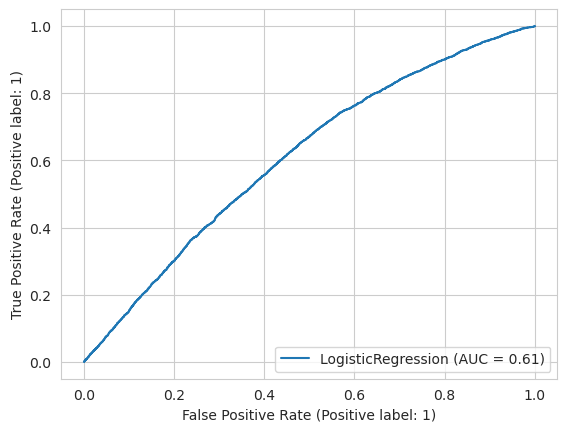

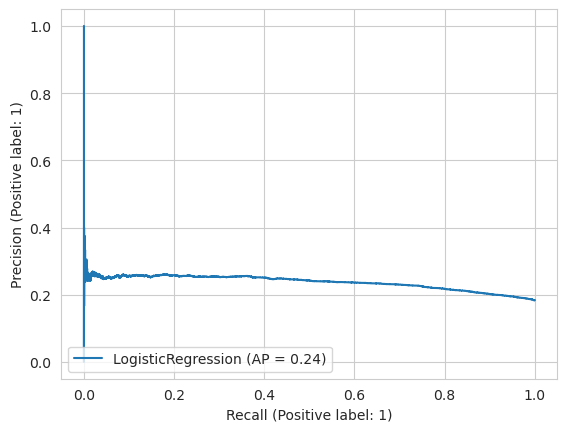

In [7]:
# V. MODEL EVALUATION==========================================================================================================================================

# LINEAR REGRESSIOn
from sklearn.metrics import r2_score
print('R^2 train: %.3f, validation: %.3f' %
(r2_score(y_train, y_train_pred),
r2_score(y_val, y_val_pred)))
#R^2 train: 0.015, validation: 0.012
print('MSE train: %.3f, test: %.3f' %(
    mean_squared_error(y_train,y_train_pred),
    mean_squared_error(y_val, y_val_pred)
))
# MSE train: 2448.770, test: 2567.939

#print('Test Accuracy %.3f' % pipe_lr.score(X_val, y_val))
    # Test accuract is 0.012
        # implication: we are underfitting
        # sol'n polynomial regression




#### Random Trees Evaluation

In [ ]:
print('R^2 train: %.3f, validation: %.3f' %
(r2_score(y_train, y_train_pred_rf),
r2_score(y_val, y_val_pred_rf)))

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.